In [6]:
%uv venv tf_gpu python=3.11
%uv venv activate tf_gpu

error: unexpected argument 'python=3.11' found

Usage: uv venv [OPTIONS] [PATH]

For more information, try '--help'.
Note: you may need to restart the kernel to use updated packages.
error: unexpected argument 'tf_gpu' found

Usage: uv venv [OPTIONS] [PATH]

For more information, try '--help'.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install tensorflow
%pip install tensorflow-metal  # <--- This is the bridge to the M2 GPU
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install numpy pandas matplotlib seaborn tensorflow scikit-learn
%pip install tensorflow-metal

  Using cached pandas-2.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunpar

In [3]:
# Cell 1 — imports, GPU check, seeds
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, auc)
import itertools
import math
import sys

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

# GPU detection for Apple Silicon
# Note: On Mac, the Metal GPU usually appears simply as "GPU:0" in list_physical_devices
gpus = tf.config.list_physical_devices('GPU')
print("Physical Devices:", gpus)

if gpus:
    print(f"✅ Metal (MPS) Acceleration Enabled. Found {len(gpus)} GPU(s).")
    # We do NOT use set_memory_growth on M2; Unified Memory is managed by macOS
else:
    print("❌ No GPU found. Running on CPU. (Did you install 'tensorflow-metal'?)")

# Determinism / seeds (best effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ModuleNotFoundError: No module named 'pandas'

In [13]:
# Cell 2 — file locate (tries common Kaggle and /mnt/data)
candidate_paths = [
    "/content/vista_sequences.fasta"
    "/kaggle/input/vista-sequence/vista_sequences.fasta",
    "Vista_Dataset/vista_sequences.fasta",
    "/mnt/data/vista_sequence.fasta",
    "/kaggle/working/vista_sequence.fasta",
    "/kaggle/input/vista-enhancers/vista_sequence.fasta",
]
fasta_path = "/content/vista_sequences.fasta"
for p in candidate_paths:
    if os.path.exists(p):
        fasta_path = p
        break
if fasta_path is None:
    raise FileNotFoundError(f"vista_sequence.fasta not found. Tried paths:\n" + "\n".join(candidate_paths))
print("Using fasta file:", fasta_path)


Using fasta file: Vista_Dataset/vista_sequences.fasta


In [14]:
# Cell 3 — parse FASTA and build dataframe
def parse_fasta_to_records(path):
    # Expect fasta headers to include label/species; if not, you may need to adapt to your fasta header format.
    records = []
    with open(path, 'r') as fh:
        header = None
        seq_lines = []
        for line in fh:
            line=line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header is not None:
                    seq = "".join(seq_lines).upper()
                    records.append((header, seq))
                header = line[1:]
                seq_lines = []
            else:
                seq_lines.append(line)
        # last
        if header is not None:
            seq = "".join(seq_lines).upper()
            records.append((header, seq))
    return records

records = parse_fasta_to_records(fasta_path)
print("Parsed sequences:", len(records))
# Inspect a few headers to ensure label extraction
for h,s in records[:5]:
    print("H:", h)


Parsed sequences: 3408
H: Human|chr16:86430087-86430726 | element 1 | positive  | neural tube[12/12] | hindbrain (rhombencephalon)[12/12] | limb[3/12] | cranial nerve[8/12]
H: Human|chr16:85620095-85621736 | element 2 | negative
H: Human|chr16:80423343-80424652 | element 3 | negative
H: Human|chr16:80372593-80373755 | element 4 | positive  | neural tube[6/10] | hindbrain (rhombencephalon)[10/10] | midbrain (mesencephalon)[10/10]
H: Human|chr16:79969907-79971297 | element 5 | negative


In [15]:
# Cell 4 — build dataframe with label extraction (try to infer from header)
rows = []
for header, seq in records:
    h = header.lower()
    # Best-effort inference:
    if "human" in h or "hs" in h:
        species = "human"
    elif "mouse" in h or "mm" in h:
        species = "mouse"
    else:
        # fallback: if file has species in separate field, split by '|' or whitespace:
        species = "unknown"
    # enhancer presence detection:
    if "enhancer" in h or "positive" in h or "pos" in h:
        enhancer_flag = 1
    elif "non" in h or "negative" in h or "neg" in h or "not" in h:
        enhancer_flag = 0
    else:
        # fallback: try numeric statuses
        enhancer_flag = None
    rows.append({"header": header, "sequence": seq, "species": species, "enhancer": enhancer_flag})

df = pd.DataFrame(rows)
print(df.shape)
df['seq_len'] = df['sequence'].str.len()
df.seq_len.describe()
# If many 'unknown' or enhancer None, print sample to let user confirm header format:
print(df['species'].value_counts(dropna=False))
print("Enhancer flag counts:", df['enhancer'].value_counts(dropna=False))
df.head(8)


(3408, 4)
species
human    2002
mouse    1406
Name: count, dtype: int64
Enhancer flag counts: enhancer
1    1750
0    1658
Name: count, dtype: int64


,header,sequence,species,enhancer,seq_len
0,Human|chr16:86430087-86430726 | element 1 | po...,AACTGAAGGGACCCCGTTAGCATATAAACAAAAGGTGGGGGGTAGC...,human,1,640
1,Human|chr16:85620095-85621736 | element 2 | ne...,GGCCCTGGTATGTTTGTTCTTCCAGGGGCTCCCAGGATGGATCCAG...,human,0,1642
2,Human|chr16:80423343-80424652 | element 3 | ne...,AAGATTGCCATTTGGGGTGTTTCTTGGGGCTAAGAACCATGAAGAC...,human,0,1310
3,Human|chr16:80372593-80373755 | element 4 | po...,GTGACAGAGACAGACAGTGACAGAGACAGATTTTAGAATTTGAACA...,human,1,1163
4,Human|chr16:79969907-79971297 | element 5 | ne...,TGACACCCACTATTATCCAGTCCTTGATAAACCTCTTTATTTGTTC...,human,0,1391
5,Human|chr16:79949950-79951518 | element 6 | ne...,AGTCACCCAGGTGGTAGTGGGCTGCAGATGCTGTGGGTTTTGTTTC...,human,0,1569
6,Human|chr16:79026563-79028162 | element 7 | ne...,ACAGAAGCCTCAAGCCTAACCAACAAGAAAGATCACTTCATATGCA...,human,0,1600
7,Human|chr16:78933253-78934686 | element 9 | ne...,TTGTTCCGGAAACCTAACTCCAAATCTTTGAACTTCCTAGAAACCT...,human,0,1434


In [16]:
# Cell 5 — filter & prepare labels for scenarios
# Scenario 1: only enhancer sequences (paper's first scenario predicted human vs mouse among enhancers).
df_enhancers = df[df['enhancer']==1].copy()
print("Enhancer sequences (for scenario1):", len(df_enhancers))

# Scenario 2: all sequences -> classes: human_enhancer, mouse_enhancer, no_enhancer
def class_label_row(r):
    if r.enhancer==1 and r.species=="human":
        return 0  # human enhancer
    if r.enhancer==1 and r.species=="mouse":
        return 1  # mouse enhancer
    return 2      # no enhancer

df['class_s2'] = df.apply(class_label_row, axis=1)
print(df['class_s2'].value_counts())


Enhancer sequences (for scenario1): 1750
class_s2
2    1658
0    1029
1     721
Name: count, dtype: int64


In [17]:
# Cell 6 — encoding schemes
INT_MAP = {'A':1,'C':3,'G':2,'T':4,'N':0}
ATOMIC_MAP = {'A':70,'C':58,'G':78,'T':66,'N':0}
EIIP_MAP = {'A':0.1260,'C':0.1340,'G':0.0806,'T':0.1335,'N':0.0}

# BFDNA: per-sequence frequencies (the paper uses for each base the frequency across the whole sequence;
# then every position mapped to that base's frequency value).
def encode_sequence_integer(seq):
    return [INT_MAP.get(b,0) for b in seq]

def encode_sequence_atomic(seq):
    return [ATOMIC_MAP.get(b,0) for b in seq]

def encode_sequence_eiip(seq):
    return [EIIP_MAP.get(b,0.0) for b in seq]

def encode_sequence_bfdna(seq):
    L = len(seq)
    # count bases
    counts = {'A':0,'C':0,'G':0,'T':0}
    for b in seq:
        if b in counts:
            counts[b]+=1
    freqs = {b: (counts[b]/L if L>0 else 0.0) for b in counts}
    # map each position to its base frequency value (paper example uses this)
    return [freqs.get(b,0.0) for b in seq]

ENCODERS = {
    'integer': encode_sequence_integer,
    'atomic': encode_sequence_atomic,
    'eiip': encode_sequence_eiip,
    'bfdna': encode_sequence_bfdna
}


In [18]:
# Cell 7 — prepare encoded arrays, pad sequences to max_len and min-max normalize per scheme
from tensorflow.keras.preprocessing.sequence import pad_sequences
def prepare_encoded_array(seqs, encoder_name, max_len_cap=2000):
    """Encode and pad sequences; truncate to max_len_cap to avoid OOM."""
    enc = ENCODERS[encoder_name]
    encoded = [enc(s) for s in seqs]
    # Cap very long sequences
    if max_len_cap:
        encoded = [x[:max_len_cap] for x in encoded]
    max_len = max(len(x) for x in encoded)
    padded = pad_sequences(encoded, maxlen=max_len, dtype='float32',
                           padding='post', truncating='post', value=0.0)
    # Min–max normalize across dataset
    minv, maxv = padded.min(), padded.max()
    if maxv > minv:
        padded = (padded - minv) / (maxv - minv)
    return padded, max_len

# Example for BFDNA
X_bfdna, maxlen_bfdna = prepare_encoded_array(df['sequence'].tolist(), 'bfdna')
print("BFDNA shape", X_bfdna.shape, "maxlen", maxlen_bfdna)


BFDNA shape (3408, 2000) maxlen 2000


In [19]:
# Cell 8 — helper: metric computations used in paper (CSI, G-mean)
def classification_metrics(y_true, y_pred, average='binary'):
    # y_true: 1d labels
    # y_pred: 1d predicted labels
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    # compute confusion matrix elements (for binary)
    if average=='binary' or len(np.unique(y_true))==2:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # CSI = Precision + TPR - 1 (paper definition)
        tpr = tp/(tp+fn) if (tp+fn)>0 else 0.0
        csi = prec + tpr - 1
        specificity = tn/(tn+fp) if (tn+fp)>0 else 0.0
        gmean = math.sqrt(rec * specificity)
    else:
        # for multiclass, compute macro variants:
        csi = None
        gmean = None
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'CSI':csi, 'G-mean':gmean, 'MCC':mcc, 'Kappa':kappa}

# multiclass macro-average ROC AUC:
def multiclass_roc_auc_score(y_true, y_proba, average="macro"):
    # y_true integer labels, y_proba: N x C
    try:
        return roc_auc_score(to_categorical(y_true), y_proba, average=average, multi_class='ovr')
    except Exception as e:
        print("roc_auc_score error:", e)
        return None


In [20]:
# Cell 9 — model builders (scenario1: binary, scenario2: multiclass)
def build_bigru_attn_scenario1(input_shape):
    inp = layers.Input(shape=input_shape)

    # --- CNN BLOCK ---
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- STACKED BIGRU BLOCK ---
    x = layers.Bidirectional(layers.GRU(96, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(96, return_sequences=False, dropout=0.3))(x)

    # Normalize GRU output
    x = layers.LayerNormalization()(x)

    # --- SELF ATTENTION ---
    att = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x[:, None, :], x[:, None, :])
    att = layers.Flatten()(att)
    att = layers.Dropout(0.2)(att)

    # --- DENSE CLASSIFIER ---
    x = layers.Dense(128, activation='relu')(att)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(1e-3),
        metrics=['accuracy']
    )
    return model




def build_bigru_attn_scenario2(input_shape, n_classes):
    inp = layers.Input(shape=input_shape)

    # --- CNN block ---
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- Stacked BiGRU ---
    x = layers.Bidirectional(layers.GRU(96, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.GRU(96, return_sequences=False, dropout=0.3))(x)

    # LayerNorm
    x = layers.LayerNormalization()(x)

    # --- Light Self Attention ---
    att = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x[:, None, :], x[:, None, :])
    att = layers.Flatten()(att)
    att = layers.Dropout(0.2)(att)

    # --- Dense ---
    out = layers.Dense(128, activation='relu')(att)
    out = layers.Dropout(0.3)(out)
    out = layers.Dense(n_classes, activation='softmax')(out)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(1e-3),
        metrics=['accuracy']
    )
    return model

In [21]:
# Cell 10 — training helper to train and evaluate a model; returns history and metrics
def train_and_evaluate_model(X, y, scenario=1, encoder_name='bfdna', batch_size=32, epochs=100):
    # X: padded 2D array (samples, seq_len). We'll reshape to (samples, seq_len, 1)
    X3 = np.expand_dims(X, -1)
    if scenario == 1:
        # binary: y are species labels for enhancer-only samples (human=0, mouse=1)
        y_bin = y  # should be 0/1
        X_train, X_temp, y_train, y_temp = train_test_split(X3, y_bin, test_size=0.30, random_state=SEED, stratify=y_bin)
        # split temp into val/test equally: 0.15 each of full
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)
        model = build_bigru_scenario1(input_shape=X3.shape[1:])
        opt = optimizers.RMSprop()
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        # multi-class: y are 0..C-1
        n_classes = len(np.unique(y))
        y_cat = to_categorical(y, num_classes=n_classes)
        X_train, X_temp, y_train, y_temp = train_test_split(X3, y_cat, test_size=0.30, random_state=SEED, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=np.argmax(y_temp, axis=1))
        model = build_bigru_scenario2(input_shape=X3.shape[1:], n_classes=n_classes)
        model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

    # Callbacks
    outdir = f"./outputs/{encoder_name}/scenario{scenario}"
    os.makedirs(outdir, exist_ok=True)
    ckpt = callbacks.ModelCheckpoint(os.path.join(outdir, "best_model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    csvlog = callbacks.CSVLogger(os.path.join(outdir, "training_log.csv"))
    # Paper trained full 500 epochs — we avoid EarlyStopping to be faithful, but you can enable it.
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[ckpt, csvlog], verbose=2)
    # load best
    model.load_weights(os.path.join(outdir, "best_model.h5"))
    # Predict
    if scenario==1:
        y_pred_prob = model.predict(X_test).ravel()
        y_pred = (y_pred_prob >= 0.5).astype(int)
        y_true = y_test
    else:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

    # metrics
    results = {}
    if scenario==1:
        auc_score = roc_auc_score(y_true, y_pred_prob)
        m = classification_metrics(y_true, y_pred, average='binary')
        m['AUC'] = auc_score
        results = m
    else:
        auc_score = multiclass_roc_auc_score(y_true, y_pred_prob)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        mcc = matthews_corrcoef(y_true, y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        # For CSI and G-mean paper printed single scores; we will leave CSI/G-mean as None for multiclass (could compute per-class)
        results = {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'CSI':None, 'G-mean':None, 'MCC':mcc, 'Kappa':kappa, 'AUC':auc_score}

    # save predictions & test y
    np.savez(os.path.join(outdir, "test_preds_and_truth.npz"), y_true=y_true, y_pred=y_pred, y_pred_prob=y_pred_prob)
    # save training history
    pd.DataFrame(history.history).to_csv(os.path.join(outdir, "history.csv"), index=False)
    return model, history, results, (X_test, y_test, y_pred, y_pred_prob)


In [ ]:
# Cell 11 — full pipeline loop over encoders and both scenarios (warning: heavy; you can run one encoder at a time)
encoders = ['integer','atomic','eiip','bfdna']
all_results = {'scenario1':{}, 'scenario2':{}}
for encoder in encoders:
      print("\n\n### Encoder:", encoder)
      X, _ = prepare_encoded_array(df['sequence'].tolist(), encoder)
      # Scenario 1 uses only enhancer sequences and species labels among enhancers
      df_e = df[df['enhancer']==1].reset_index(drop=True)
      X_e, _ = prepare_encoded_array(df_e['sequence'].tolist(), encoder)
      # species mapping among enhancers:
      species_map = df_e['species'].map({'human':0,'mouse':1}).fillna(0).astype(int).values
      # Train scenario1
      print("Training Scenario 1 (human vs mouse enhancers) for encoder", encoder)
      model1, hist1, res1, testinfo1 = train_and_evaluate_model(X_e, species_map, scenario=1, encoder_name=encoder, batch_size=32, epochs = 30 if encoder == 'bfdna' else 30
  )
      all_results['scenario1'][encoder] = res1
      print("Scenario1 results:", res1)
      # Scenario2: multiclass
      print("Training Scenario 2 (human enhancer / mouse enhancer / no enhancer) for encoder", encoder)
      # class_s2 in df already (0 human enh,1 mouse enh,2 no enhancer)
      X_all, _ = prepare_encoded_array(df['sequence'].tolist(), encoder)
      classes_s2 = df['class_s2'].values
      model2, hist2, res2, testinfo2 = train_and_evaluate_model(X_all, classes_s2, scenario=2, encoder_name=encoder, batch_size=32, epochs = 30 if encoder == 'bfdna' else 30
  )
      all_results['scenario2'][encoder] = res2
      print("Scenario2 results:", res2)
      # Save intermediate results
      pd.DataFrame(all_results).to_csv(f"./outputs/{encoder}_summary_results.csv")




### Encoder: integer
Training Scenario 1 (human vs mouse enhancers) for encoder integer
Epoch 1/30

Epoch 1: val_loss improved from None to 0.77833, saving model to ./outputs/integer/scenario1/best_model.h5


39/39 - 17s - 443ms/step - accuracy: 0.5788 - loss: 0.7248 - val_accuracy: 0.4122 - val_loss: 0.7783
Epoch 2/30

Epoch 2: val_loss did not improve from 0.77833
39/39 - 13s - 336ms/step - accuracy: 0.6041 - loss: 0.6691 - val_accuracy: 0.4122 - val_loss: 0.9022
Epoch 3/30

Epoch 3: val_loss did not improve from 0.77833
39/39 - 15s - 393ms/step - accuracy: 0.6171 - loss: 0.6666 - val_accuracy: 0.4122 - val_loss: 1.3747
Epoch 4/30

Epoch 4: val_loss did not improve from 0.77833
39/39 - 17s - 440ms/step - accuracy: 0.6408 - loss: 0.6418 - val_accuracy: 0.4122 - val_loss: 1.3307
Epoch 5/30

Epoch 5: val_loss did not improve from 0.77833
39/39 - 16s - 419ms/step - accuracy: 0.6563 - loss: 0.6228 - val_accuracy: 0.4122 - val_loss: 1.0311
Epoch 6/30

Epoch 6: val_loss did not improve from 0.77833
39/39 - 16s - 400ms/step - accuracy: 0.6865 - loss: 0.5973 - val_accuracy: 0.4122 - val_loss: 1.4228
Epoch 7/30

Epoch 7: val_loss did not improve from 0.77833
39/39 - 16s - 405ms/step - accuracy: 0.6

In [12]:
# Cell 12 — plotting helpers (example: training curves, ROC, confusion matrix)
import itertools
def plot_training(history_csv_path=None, history_obj=None, outpath=None):
    if history_obj is not None:
        history_df = pd.DataFrame(history_obj.history)
    else:
        history_df = pd.read_csv(history_csv_path)
    plt.figure(figsize=(10,4))
    if 'loss' in history_df.columns:
        plt.subplot(1,2,1)
        plt.plot(history_df['loss'], label='train_loss')
        plt.plot(history_df['val_loss'], label='val_loss')
        plt.legend(); plt.title("Loss")
    if 'accuracy' in history_df.columns:
        plt.subplot(1,2,2)
        plt.plot(history_df['accuracy'], label='train_acc')
        plt.plot(history_df['val_accuracy'], label='val_acc')
        plt.legend(); plt.title("Accuracy")
    if outpath:
        plt.savefig(outpath)
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, outpath=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.title(title)
    if outpath:
        plt.savefig(outpath)
    plt.show()

def plot_roc_binary(y_true, y_prob, outpath=None):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend()
    if outpath:
        plt.savefig(outpath)
    plt.show()



--- Plotting for Scenario 1 (bfdna encoder) ---
Plotting Training History for Scenario 1...


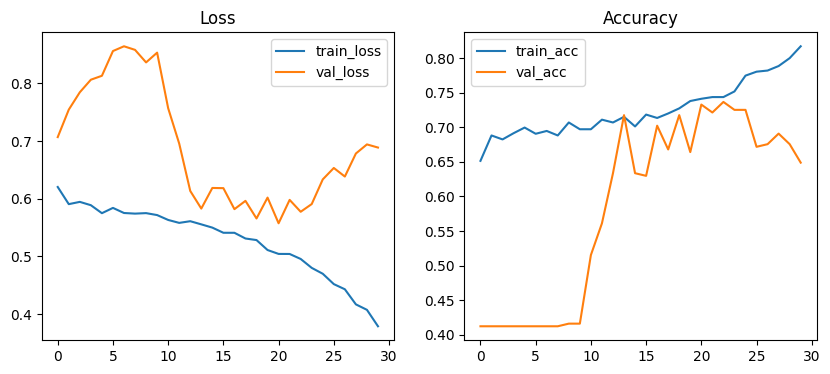

Loading test predictions for Scenario 1...
Plotting Confusion Matrix for Scenario 1...


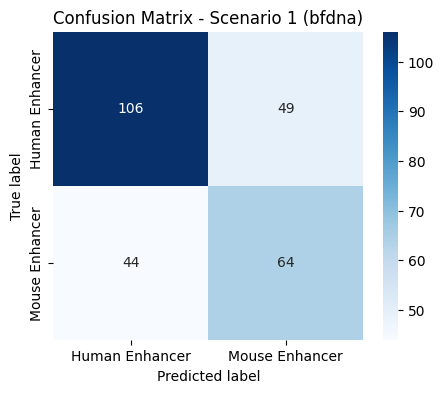

Plotting ROC Curve for Scenario 1...


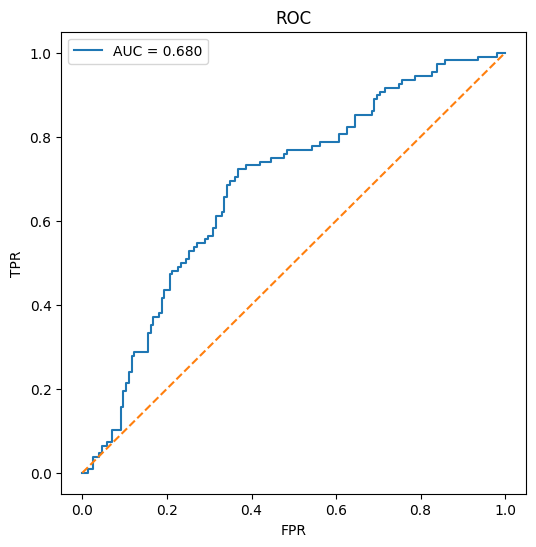


--- Plotting for Scenario 2 (bfdna encoder) ---
Plotting Training History for Scenario 2...


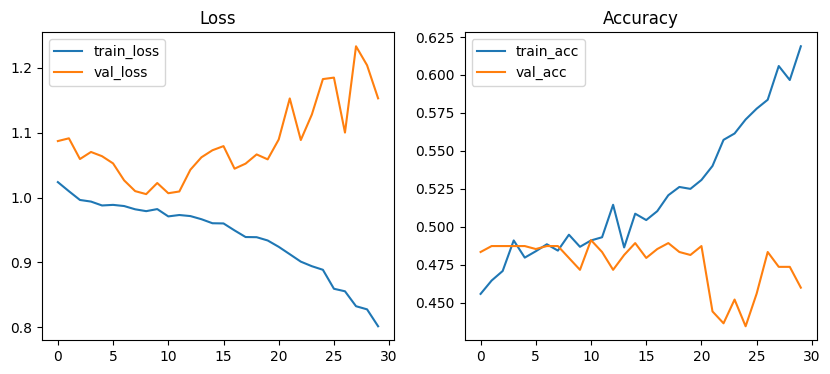

Loading test predictions for Scenario 2...
Plotting Confusion Matrix for Scenario 2...


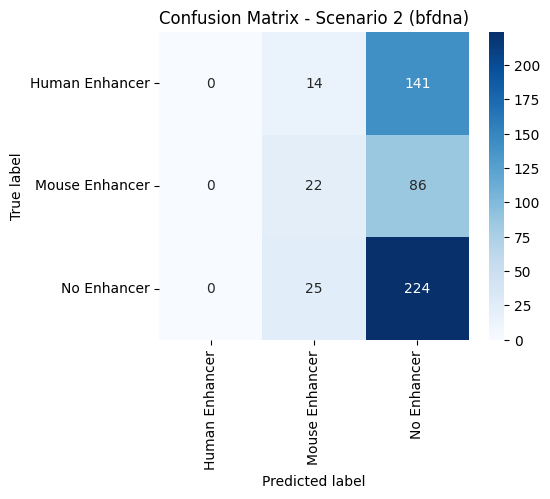

Note: Multi-class ROC curves require a specialized plotting function not provided in the helpers.


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

encoder_to_plot = 'bfdna'

# --- Scenario 1 Plots ---
print(f"\n--- Plotting for Scenario 1 ({encoder_to_plot} encoder) ---")
outdir_s1 = f"./outputs/{encoder_to_plot}/scenario1"

# Plot Training History for Scenario 1
print("Plotting Training History for Scenario 1...")
plot_training(history_csv_path=os.path.join(outdir_s1, "training_log.csv"), outpath=os.path.join(outdir_s1, "training_history.png"))

# Load test predictions for Scenario 1
print("Loading test predictions for Scenario 1...")
data_s1 = np.load(os.path.join(outdir_s1, "test_preds_and_truth.npz"))
y_true_s1 = data_s1['y_true']
y_pred_s1 = data_s1['y_pred']
y_pred_prob_s1 = data_s1['y_pred_prob']

# Plot Confusion Matrix for Scenario 1
print("Plotting Confusion Matrix for Scenario 1...")
cm_s1 = confusion_matrix(y_true_s1, y_pred_s1)
plot_confusion_matrix(cm_s1, classes=['Human Enhancer', 'Mouse Enhancer'], title=f'Confusion Matrix - Scenario 1 ({encoder_to_plot})', outpath=os.path.join(outdir_s1, "confusion_matrix.png"))

# Plot ROC Curve for Scenario 1
print("Plotting ROC Curve for Scenario 1...")
plot_roc_binary(y_true_s1, y_pred_prob_s1, outpath=os.path.join(outdir_s1, "roc_curve.png"))

# --- Scenario 2 Plots ---
print(f"\n--- Plotting for Scenario 2 ({encoder_to_plot} encoder) ---")
outdir_s2 = f"./outputs/{encoder_to_plot}/scenario2"

# Plot Training History for Scenario 2
print("Plotting Training History for Scenario 2...")
plot_training(history_csv_path=os.path.join(outdir_s2, "training_log.csv"), outpath=os.path.join(outdir_s2, "training_history.png"))

# Load test predictions for Scenario 2
print("Loading test predictions for Scenario 2...")
data_s2 = np.load(os.path.join(outdir_s2, "test_preds_and_truth.npz"))
y_true_s2 = data_s2['y_true']
y_pred_s2 = data_s2['y_pred']
y_pred_prob_s2 = data_s2['y_pred_prob']

# Plot Confusion Matrix for Scenario 2
print("Plotting Confusion Matrix for Scenario 2...")
# The number of classes for Scenario 2 are 3: 0 (human enhancer), 1 (mouse enhancer), 2 (no enhancer)
cm_s2 = confusion_matrix(y_true_s2, y_pred_s2)
class_names_s2 = ['Human Enhancer', 'Mouse Enhancer', 'No Enhancer']
plot_confusion_matrix(cm_s2, classes=class_names_s2, title=f'Confusion Matrix - Scenario 2 ({encoder_to_plot})', outpath=os.path.join(outdir_s2, "confusion_matrix.png"))

print("Note: Multi-class ROC curves require a specialized plotting function not provided in the helpers.")